# Experiment plotting

This notebook contains the code for plotting results for the different experiments.
When run for the first time for a town, condensed summary files are being created which strongly speed up subsequent generations of plots from the same summaries. It is possible to create the plots only from the condensed summaries located in 'summaries/condensed_summaries'.
Note that this works for all experiments but the Rt plots, which still require the full summary file.


In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import os
import pandas as pd
import pickle
from lib.measures import *
from lib.experiment import Experiment, Plot, Result, get_properties, load_summary_list, load_summary
from lib.data import collect_data_from_df
from lib.calibrationFunctions import get_calibrated_params, downsample_cases
import lib.plot as lib_plot
from lib.plot import Plotter
from lib.plot import extract_data_from_summary, load_extracted_data
from lib.experiment import load_config

In [47]:
places = ['tuebingen']#, ('GER', 'RH'), ('GER', 'KL'), ('CH', 'TI'), ('CH', 'BE'), ('CH', 'JU')]

ymax_interventions = {'CH' : {'TI': 1000, 'BE': 2000, 'JU': 3000},
                      'GER': {'TU': 2000, 'RH': 800, 'KL': 500}}

ymax_tracing =  {'CH' : {'TI' : 50, 'JU': 200, 'BE': 300},
                 'GER' : {'TU' : 350, 'RH': 150, 'KL': 100}}

ymax_modelfit = {'GER': {'TU': 1200, 'KL': 500, 'RH': 749, 'TR': 2000,},
                 'CH': {'VD': 2000, 'BE': 590, 'TI': 500, 'JU': 500,}}

## Model fit

In [49]:
def plot_model_fit(area, ymax, show_legend=True):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    config = load_config(f'lib/settings/{area}_config.py')
    country = config.country
    area = config.area
    print(country)
    
    plots = {
        f'model-fit-{country}-{area}' : [
            Plot(label='Simulated cases', 
                path=(f'continued-lockdown-{country}-{area}/'
                      f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=100.pk')),
        ],
    }
    
    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # load simulations
        results = load_summary_list(paths)
        sims = get_properties(results, 'metadata')
        summaries = get_properties(results, 'summary')

        # plots
        plotter = Plotter()

        start_date = config.calibration_start_dates
        start_date_lockdown = config.calibration_lockdown_dates['start']
        end_date = config.calibration_end_dates

        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days        
        
        mob_settings_paths = config.mobility_settings['full scale']
        with open(mob_settings_paths, 'rb') as fp:
            mob_settings = pickle.load(fp)

        area_cases = collect_data_from_df(config=config,
             datatype='new',
             start_date_string=start_date,
             end_date_string=end_date)

        sim_cases = downsample_cases(area_cases, mob_settings)      # only downscaling due LK data for cities
        
        ts, predicted = plotter.plot_positives_vs_target(
            paths, 
            labels,
            sim_cases.sum(axis=1),
            title='Calibration period',
            filename=plot_filename,
            figsize=lib_plot.FIG_SIZE_NEURIPS_TRIPLE,
            figformat='neurips-double',
            start_date=start_date,
            errorevery=1, acc=500,
            lockdown_label='Interventions',
            ymax=ymax[country][area],
            lockdown_at=days_until_lockdown,
            lockdown_label_y=ymax[country][area]/8,
            small_figure=True,
            show_legend=show_legend
            #subplot_adjust={'bottom': 0.2, 'top': 2.0, 'left': 0.1, 'right': 1}
        )
        
        def idx_closest_to(arr, val):
            return (np.abs(arr - val)).argmin()
        
        # compute `relative mean absolute error averaged across days`
        target = sim_cases.sum(axis=1)
        errors = []
        for day in range(target.shape[0] ): 
            approx_idx = idx_closest_to(ts, day)
                        
            # compute error on day `day`
            errors.append(
                # 100 * np.abs(predicted[approx_idx] - target[day]) / target[day] # relative MAE
                np.abs(predicted[approx_idx] - target[day]) # MAE
            )
        error = np.mean(errors)
        
    return error
        

tuebingen
GER
Loaded previously extracted data.
Errors: [30.01362179487179]
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.


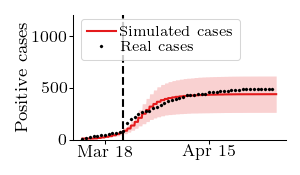

In [53]:
errors = []
for area in places:
    print(area)
    err = plot_model_fit(area, ymax_modelfit, show_legend=True)
    errors.append(err)

print('Errors: ' + str(errors))

# Crop pdf margins
!bash crop_pdfs.sh plots/model-fit-*.pdf

# Counterfactual analyses

### Continued lockdown

In [57]:
def plot_continued_lockdown(area, ymax, xtick_interval, plot_rt=False):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    config = load_config(f'lib/settings/{area}_config.py')
    country = config.country
    area = config.area
    
    plots = {
        f'continued-lockdown-{country}-{area}' : [
            Plot(label='No interventions',
                path=(f'baseline-{country}-{area}/'
                      f'baseline-{country}-{area}-baseline.pk')),
            Plot(label='Lockdown', 
                path=(f'continued-lockdown-{country}-{area}/'
                      f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=100.pk')),
            Plot(label='Open after 2 weeks', 
                path=(f'continued-lockdown-{country}-{area}/'
                      f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=2.pk')),
            Plot(label='Open after 4 weeks',
                path=(f'continued-lockdown-{country}-{area}/'
                      f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=4.pk')),
        ],
    }


    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # plots
        plotter = Plotter()

        start_date = config.calibration_start_dates
        start_date_lockdown = config.calibration_lockdown_dates['start']
        end_date = config.calibration_end_dates

        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days

        plotter.compare_total_infections(
            paths, 
            titles=labels, 
            filename=plot_filename, 
            start_date=start_date,
#             figsize=lib_plot.FIG_SIZE_NEURIPS_DOUBLE_TALL, 
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV, 
            figformat='neurips-double',
            legend_is_left=False,
            lockdown_label='Interventions',
            lockdown_at=days_until_lockdown,
            lockdown_xshift=0.0,
            lockdown_label_y=0.25,
            ymax=ymax[country][area],
            xtick_interval=xtick_interval[country][area],
            errorevery=14)
        
        if plot_rt:
            indices = [1, 3]    # Show Rt for the best working strategy only
            
            paths = [paths[i] for i in indices]
            results = load_summary_list(paths)
            sims = get_properties(results, 'metadata')
            summaries = get_properties(results, 'summary')
        
            for summary, sim, path in zip(summaries, sims, paths):
                #plot_name = sim.experiment_info
                _, plot_name = os.path.split(path)
                plot_name = plot_name[:-3]
                plotter.plot_daily_rts(summary, 
                                       filename=plot_name+'-Rt', 
                                       start_date=start_date, 
                                       titles=None,
                                       figsize=(6,4), 
                                       lockdown_label='Interventions',
                                       lockdown_at=days_until_lockdown, 
                                       lockdown_label_y=10.0, 
                                       ymax=None, 
                                       errorevery=1, 
                                       )

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.


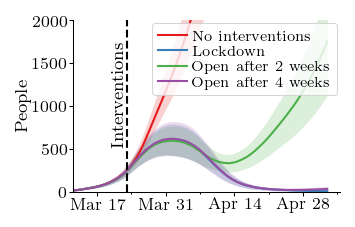

In [59]:
ymax = {'CH' : {'TI': 5000, 'BE': 40000, 'JU': 25000},
       'GER': {'TU': 4000, 'RH': 2000, 'KL': 750}}

xtick_interval = {
    'GER': {'RH': 2, 'TU': 2, 'KL': 3},
    'CH': {'BE': 4, 'JU': 4, 'TI': 4},
}

for area in places:
    if area not in ['BE', 'RH']:
         continue
    print(area)
plot_continued_lockdown(area, ymax_interventions, xtick_interval, plot_rt=False)
    
# Crop pdf margins
!bash crop_pdfs.sh plots/continued-lockdown-*.pdf
# !bash crop_pdfs.sh plots/realistic-scenario-*.pdf

### K groups

In [63]:
def plot_k_groups(area, ymax, xtick_interval, plot_rt=False):
    config = load_config(f'lib/settings/{area}_config.py')
    country = config.country
    area = config.area
    
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'k-groups-{country}-{area}' : [
            Plot(label='No interventions',
                path=(f'baseline-{country}-{area}/'
                      f'baseline-{country}-{area}-baseline.pk')),
            Plot(label='Lockdown', 
                path=(f'continued-lockdown-{country}-{area}/'
                      f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=100.pk')),
            Plot(label='K = 2',
                path=(f'k-groups-{country}-{area}/'
                      f'k-groups-{country}-{area}-K_groups=2.pk')),
            Plot(label='K = 3',
                path=(f'k-groups-{country}-{area}/'
                      f'k-groups-{country}-{area}-K_groups=3.pk')),
            Plot(label='K = 4', 
                path=(f'k-groups-{country}-{area}/'
                      f'k-groups-{country}-{area}-K_groups=4.pk')),
        ],

    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # plots
        plotter = Plotter()

        start_date = config.calibration_start_dates
        start_date_lockdown = config.calibration_lockdown_dates['start']
        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days

        plotter.compare_total_infections(
            paths,
            titles=labels, 
            filename=plot_filename, 
            start_date=start_date,
#             figsize=lib_plot.FIG_SIZE_NEURIPS_DOUBLE_TALL, 
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV, 
            figformat='neurips-double',
            legend_is_left=False,
            lockdown_label='Interventions',
            lockdown_at=days_until_lockdown,
            lockdown_xshift=0.0,
            lockdown_label_y=0.25,
            ymax=ymax[country][area], 
            xtick_interval=xtick_interval[country][area],
            errorevery=14)
        
        
        if plot_rt:
            indices = [2]    # Show Rt for the best working strategy only
            
            paths = [paths[i] for i in indices]
            results = load_summary_list(paths)
            sims = get_properties(results, 'metadata')
            summaries = get_properties(results, 'summary')
        
            for summary, sim in zip(summaries, sims):
                plot_name = sim.experiment_info
                plotter.plot_daily_rts(summary, 
                                       filename=plot_name+'-Rt', 
                                       start_date=start_date, 
                                       titles=None,
                                       figsize=(6,4), 
                                       lockdown_label='Interventions',
                                       lockdown_at=days_until_lockdown, 
                                       lockdown_label_y=3, 
                                       ymax=None, 
                                       errorevery=1, 
                                       )

tuebingen
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Optimize sigma using maximum likelihood estimation...
 0.50: 47
 0.50: 47
 0.01: 47
 0.01: 47
 0.43: 47
 0.43: 47
 0.27: 47
 0.27: 47
 0.34: 47
 0.34: 47
 0.33: 47
 0.33: 47
 0.33: 47
 0.33: 47
 0.33: 47
 0.33: 47
done. Best sigma found at: 0.33
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.


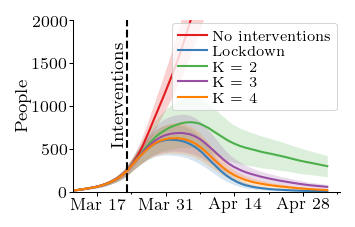

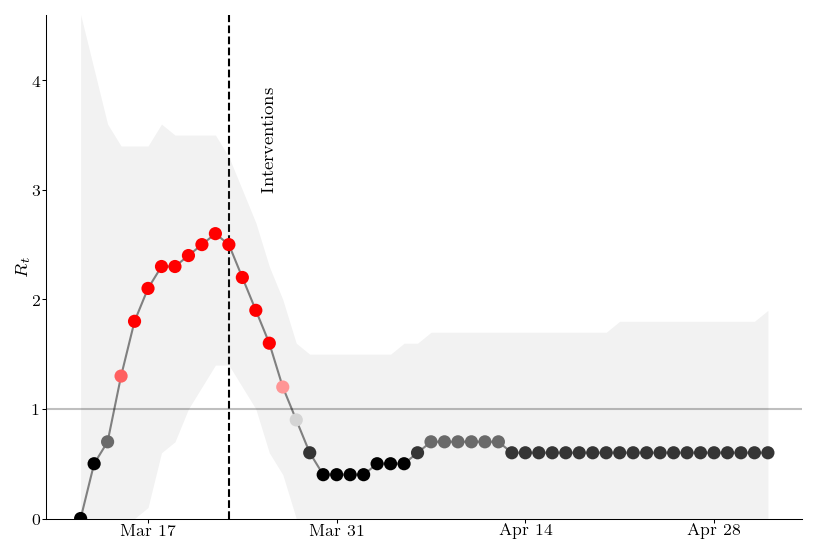

In [64]:
#ymax = {'CH' : {'TI': 750, 'BE': 1000, 'JU': 2000},
#        'GER': {'TU': 1200, 'RH': 500, 'KL': 250}}

xtick_interval = {
    'GER': {'RH': 2, 'TU': 2, 'KL': 3},
    'CH': {'BE': 4, 'JU': 4, 'TI': 4},
}

for area in places:
#     if area not in ['KL', 'JU']:
#         continue
    print(area)
    plot_k_groups(area, ymax_interventions, xtick_interval, plot_rt=True)
    
# Crop pdf margins
!bash crop_pdfs.sh plots/k-groups-*.pdf

### Vulnerable Groups


In [66]:
def plot_vulnerable_groups(area, ymax, ymax_hosp, xtick_interval):
    config = load_config(f'lib/settings/{area}_config.py')
    country = config.country
    area = config.area
    
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'vulnerable-groups-{country}-{area}' : [
            Plot(label='No interventions',
                path=(f'baseline-{country}-{area}/'
                      f'baseline-{country}-{area}-baseline.pk')),
            Plot(label='Lockdown', 
                path=(f'continued-lockdown-{country}-{area}/'
                      f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=100.pk')),
            Plot(label='Vulnerable groups', 
                path=(f'vulnerable-groups-{country}-{area}/'
                      f'vulnerable-groups-{country}-{area}-.pk')),
        ],

    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # plots
        plotter = Plotter()

        start_date = config.calibration_start_dates
        start_date_lockdown = config.calibration_lockdown_dates['start']
        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days

        plotter.compare_total_infections(
            paths,
            titles=labels, 
            filename=plot_filename, 
            start_date=start_date,
#             figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV, 
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV_SMALL, 
            figformat='neurips-double',
            legend_is_left=False,
            lockdown_label='Interventions',
            lockdown_at=days_until_lockdown,
            lockdown_xshift=0.0,
            lockdown_label_y=0.25,
            ymax=ymax[country][area], 
            xtick_interval=xtick_interval[country][area],
            errorevery=14)

        
        
        plotter.compare_total_fatalities_and_hospitalizations(
            paths,
            titles=labels, 
            mode='show_hosp_only',
            filename=plot_filename+ '-hosp', 
            start_date=start_date,
#             figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV, 
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV_SMALL, 
            figformat='neurips-double',
            legend_is_left=False,
            lockdown_xshift=0.0,
            lockdown_at=days_until_lockdown,
            lockdown_label='Interventions',
            lockdown_label_y=0.25,
            ymax=ymax_hosp[country][area], 
            xtick_interval=xtick_interval[country][area],
            errorevery=14)
        
        plotter.compare_total_fatalities_and_hospitalizations(
            paths,
            titles=labels, 
            mode='show_dead_only',
            filename=plot_filename+ '-dead', 
            start_date=start_date,
#             figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV, 
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV_SMALL, 
            figformat='neurips-double',
            legend_is_left=False,
            lockdown_xshift=0.0,
            lockdown_at=days_until_lockdown,
            lockdown_label='Interventions',
            lockdown_label_y=0.25,
            ymax=ymax_hosp[country][area], 
            xtick_interval=xtick_interval[country][area],
            errorevery=14)
        
    

tuebingen
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.


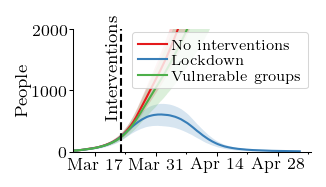

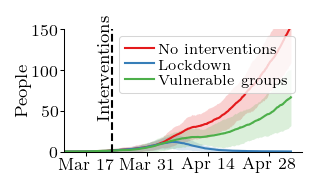

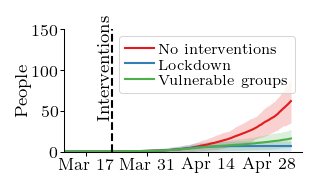

In [67]:
#ymax = {'CH' : {'TI': 5000, 'BE': 35000, 'JU': 25000},
#        'GER': {'TU': 4000, 'RH': 3000, 'KL': 1500}}

ymax_hosp = {
    'CH' : {'TI' : 120, 'BE': 800, 'JU': 500},
    'GER': {'TU': 150, 'RH': 25, 'KL': 18}
}

xtick_interval = {
    'GER': {'RH': 2, 'TU': 2, 'KL': 3},
    'CH': {'BE': 4, 'JU': 4, 'TI': 4},
}

for area in places:
    print(area)
    plot_vulnerable_groups(area, ymax_interventions, ymax_hosp, xtick_interval)
    
# Crop pdf margins
!bash crop_pdfs.sh plots/vulnerable-groups-*.pdf

# Contact tracing

### Contact tracing test delay and testing

In [68]:
def plot_contact_tracing_isolation(area, ymax, single_runs=False, plot_rt=False):
    config = load_config(f'lib/settings/{area}_config.py')
    country = config.country
    area = config.area
    
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'tracing-{country}-{area}' : [
            Plot(label='Isolate \& test all, 48h delay',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate+test-delay=48.0-contacts_tested=100000-test_policy=basic.pk')),
            Plot(label='Isolate only, 48h delay',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate-delay=48.0-contacts_tested=None-test_policy=None.pk')),
            Plot(label='Isolate only, 3h delay',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate-delay=3.0-contacts_tested=None-test_policy=None.pk')),
        ]
    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # plots
        plotter = Plotter()

        plotter.compare_total_infections(
            paths, 
            titles=labels, 
            filename=plot_filename, 
            show_single_runs=False,
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV, 
            figformat='neurips-double',
            legend_is_left=True,
            ymax=ymax[country][area],
            x_axis_dates=False,
            xtick_interval=3,
            errorevery=14)

        
        if single_runs:
            plotter.compare_total_infections(
                paths, 
                titles=labels, 
                filename=plot_filename + '-single', 
                show_single_runs=3,
                figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV, 
                figformat='neurips-double',
                legend_is_left=True,
                ymax=ymax[country][area],
                x_axis_dates=False,
                xtick_interval=3,
                errorevery=14)
        

tuebingen
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.


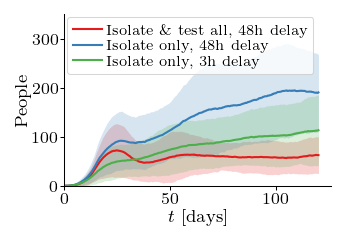

In [69]:
#ymax = {
#    'CH' : {'TI' : 50, 'JU': 200, 'BE': 300},
#    'GER' : {'TU' : 350, 'RH': 120, 'KL': 90},
#}

for area in places:
#     if area != 'TU':
#         continue
    print(area)
    plot_contact_tracing_isolation(area, ymax_tracing, plot_rt=False)
    
# Crop pdf margins
!bash crop_pdfs.sh plots/tracing-*.pdf

### Adoption levels of contact tracing with isolation and testing

In [70]:
def plot_tracing_isolation_compliance(area, ymax, single_runs=False):
    config = load_config(f'lib/settings/{area}_config.py')
    country = config.country
    area = config.area
    
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'tracing-compliance-{country}-{area}' : [
            Plot(label='No interventions', 
                path=(f'baseline-scenario-b-{country}-{area}/'
                      f'baseline-scenario-b-{country}-{area}-baseline.pk')),
            Plot(label='25\% compliance',
                path=(f'tracing-compliance-{country}-{area}/'
                      f'tracing-compliance-{country}-{area}-p=0.25.pk')),
            Plot(label='50\% compliance',
                path=(f'tracing-compliance-{country}-{area}/'
                      f'tracing-compliance-{country}-{area}-p=0.5.pk')),
            Plot(label='65\% compliance',
                path=(f'tracing-compliance-{country}-{area}/'
                      f'tracing-compliance-{country}-{area}-p=0.65.pk')),
            Plot(label='75\% compiance',
                path=(f'tracing-compliance-{country}-{area}/'
                      f'tracing-compliance-{country}-{area}-p=0.75.pk')),
            Plot(label='100\% compliance',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate+test-delay=48.0-contacts_tested=100000-test_policy=basic.pk')),
        ]
    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # plots
        plotter = Plotter()

        plotter.compare_total_infections(
            paths, 
            titles=labels, 
            filename=plot_filename, 
            show_single_runs=False,
#             figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV, 
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
            figformat='neurips-double',
            legend_is_left=True,
            lockdown_label_y=1000,
            ymax=ymax[country][area],
            x_axis_dates=False,
            xtick_interval=3,
            errorevery=14)
        
        if single_runs:
            plotter.compare_total_infections(
                paths, 
                titles=labels, 
                filename=plot_filename + '-single', 
                show_single_runs=5,
#                 figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV, 
                figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
                figformat='neurips-double',
                legend_is_left=True,
                lockdown_label_y=1000,
                ymax=ymax[country][area] * 1.5,
                xtick_interval=3,
                errorevery=14)

        

tuebingen
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.


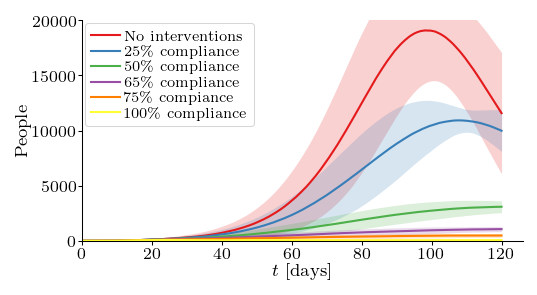

In [71]:
ymax = {'CH' : {'TI': 3500, 'BE': 40000, 'JU': 25000},
        'GER': {'TU': 20000, 'KL': 2000, 'RH': 3500}}

for area in places:
#     if area != 'TU': 
#         continue
    print(area)
    try:
        plot_tracing_isolation_compliance(area, ymax)
    except FileNotFoundError:
        print('Summaries not found.')
        
# Crop pdf margins
!bash crop_pdfs.sh plots/tracing-compliance-*.pdf

### Increased efficiency using the advanced testing policy

In [74]:
def plot_advanced_testing_policy(area, ymax, plot_daily_tested=False):
    config = load_config(f'lib/settings/{area}_config.py')
    country = config.country
    area = config.area
    
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'tracing-test-efficiency-{country}-{area}' : [
            Plot(label='Isolate \& test all',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate+test-delay=48.0-contacts_tested=100000-test_policy=basic.pk')),
            Plot(label='Isolate \& test top 20 risk',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate+test-delay=48.0-contacts_tested=20-test_policy=advanced.pk')),
        ]
    }

    for plot_filename, plots in plots.items():
        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # plots
        plotter = Plotter()

        plotter.compare_total_infections(
             paths, 
             titles=labels, 
             filename=plot_filename, 
             show_single_runs=False,
             figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV, 
             figformat='neurips-double',
             legend_is_left=True,
             ymax=ymax[country][area],
             x_axis_dates=False,
             errorevery=14)
        
        try:
            positive_tests = dict()
            negative_tests = dict()
            total_tests = dict()
            strategies =  ['standard', 'efficient']
            for path, strategy in zip(paths, strategies):
                data = load_extracted_data(path, acc=500)
                positive_tests[strategy] = data['posi_mu'][-1]
                negative_tests[strategy] = data['nega_mu'][-1]
                total_tests[strategy] = positive_tests[strategy] + negative_tests[strategy]
            relative_positive = positive_tests['efficient'] / positive_tests['standard']
            relative_negative = negative_tests['efficient'] / negative_tests['standard']
            print(f'Relative numbers of tests with efficient testing strategy: \n'
                  f'Positive: {relative_positive * 100}%, Negative: {relative_negative * 100}% \n'
                  f'Total tests standard: {np.round(total_tests["standard"])}, total tests efficient: {np.round(total_tests["efficient"])}\n'
                  f'Conducted tests reduced by {np.round( (1 - total_tests["efficient"] / total_tests["standard"]) * 100)}%')
        except KeyError:
            print(f'Condensed summary is missing required keys. Delete corresponding condensed summary and run again.')
              
        
        if plot_daily_tested:
            # load simulations
            results = load_summary_list(paths)
            sims = get_properties(results, 'metadata')
            summaries = get_properties(results, 'summary')
            
            for summary, label in zip(summaries, labels):
                plotter.plot_daily_tested(
                    summary, 
                    title=label, 
                    filename=plot_filename + '-' + label, 
                    acc=500)
            
            

tuebingen
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Relative numbers of tests with efficient testing strategy: 
Positive: 106.82061477290105%, Negative: 17.64542373981145% 
Total tests standard: 47927.0, total tests efficient: 8821.0
Conducted tests reduced by 82.0%
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.


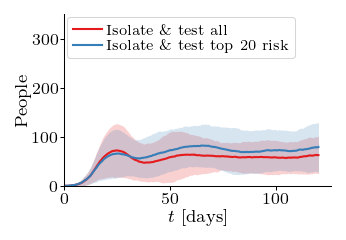

In [75]:
#ymax = {
#    'CH' : {'TI' : 60, 'BE': 220, 'JU': 140},
#    'GER' : {'TU' : 200, 'KL': 120, 'RH': 120},
#}

for area in places:
    print(area)
#     if area != 'TU':
#         continue
    plot_advanced_testing_policy(area, ymax_tracing)
    
# Crop pdf margins
!bash crop_pdfs.sh plots/tracing-test-efficiency-*.pdf

## Conditional Measures

In [76]:
def plot_conditional_measures(area, ymax, show_mean=False):
    config = load_config(f'lib/settings/{area}_config.py')
    country = config.country
    area = config.area
    
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'conditional-measures-scenario-b-{country}-{area}' : [
            Plot(label='No interventions', 
                 path=(f'baseline-scenario-b-{country}-{area}/'
                       f'baseline-scenario-b-{country}-{area}-baseline.pk')),
            Plot(label='Conditional measures',
                path=(f'conditional-measures-scenario-b-{country}-{area}/'
                      f'conditional-measures-scenario-b-{country}-{area}-max_pos_tests_per_week_per_100k=50-initially_active=False.pk')),
        ]
    }
    
    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # plots
        plotter = Plotter()

        if show_mean:
            plotter.compare_total_infections(
                paths, 
                titles=labels, 
                filename=plot_filename, 
                show_single_runs=False,
                figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV, 
                figformat='neurips-double',
                legend_is_left=True,
                conditional_measures=1,
                ymax=ymax[country][area],
                x_axis_dates=False,
                errorevery=14)
        
        which_single_runs = [6, ]
        
        for which_single_run in which_single_runs:
            plotter.compare_total_infections(
                paths, 
                titles=labels, 
                filename=plot_filename + f'-single-run-{which_single_run}', 
                show_single_runs=1,
                which_single_runs=which_single_run,
                figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV, 
                figformat='neurips-double',
                legend_is_left=True,
                conditional_measures=1,
                ymax=ymax[country][area],
                x_axis_dates=False,
                errorevery=14)
        
        data = load_extracted_data(paths[1], acc=500)
        try:
            lockdown_time_proportion = data['mean_lockdown_time'] / data['max_time']
            print(f'Lockdown was active for {lockdown_time_proportion * 100}% of the time.')
        except KeyError:
            print(f'Condensed summary is missing required keys. Delete corresponding condensed summary and run again.')

tuebingen
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Lockdown was active for 41.28257603506982% of the time.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.


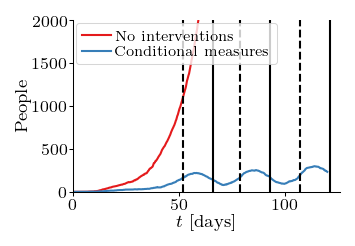

In [77]:
#ymax = {
#    'CH' : {'TI' : 400, 'JU': 600, 'BE': 800},
#    'GER' : {'TU' : 400, 'KL': 400, 'RH': 600},
#}

# BE is broken somehow, some simulations yielded enormously many cases

xtick_interval = {
    'GER': {'RH': 2, 'TU': 2, 'KL': 3},
    'CH': {'BE': 4, 'JU': 4, 'TI': 4},
}

for area in places:
#     if area not in ['BE', 'TU']:
#         continue
    print(area)
    plot_conditional_measures(area, ymax_interventions)
    
# Crop pdf margins
!bash crop_pdfs.sh plots/conditional-measures-scenario-b-*.pdf

## Narrowcasting Plot

In [81]:
from lib.town_maps import MapIllustrator
import importlib
bboxes = dict()
areas = {'TU': 'tubingen', 'KL': 'kaiserslautern', 'RH': 'ruedesheim', 'TI': 'locarno', 'BE': 'bern', 'JU': 'jura'}
for area, name in areas.items():
    globals()['bbox'] = importlib.import_module(f'lib.settings.town_settings_{name}')
    bboxes[area] = bbox.bbox

In [82]:
def plot_narrowcasting(area):
    config = load_config(f'lib/settings/{area}_config.py')
    country = config.country
    area = config.area
    
    TO_HOURS = 24.0
    day_start = 7
    day_duration = 14
    # make sure to load a summary file that had `store_mob = True`
    path = f'narrowcasting-{country}-{area}/narrowcasting-{country}-{area}-single.pk'
    summary = load_summary(path)
    summary = summary[1]
    mob = summary.mob[0]

    # plot
    ill = MapIllustrator()
    ill.marker_radius = 10.0
    map_name = f'narrowcasting-plot-{country}-{area}-{day_start}-{day_duration}'

    sitemap = ill.empirical_infection_probability_map(
        bbox=bboxes[area],
        site_loc=mob.site_loc, 
        site_type=mob.site_type, 
        site_dict=mob.site_dict, 
        map_name=map_name, 
        sim=summary, 
        t0=TO_HOURS * day_start, 
        t1=TO_HOURS * (day_start + day_duration), 
        scaling_markersize=0.3,
        delta=0.0, 
        r=0)
    return sitemap

In [83]:
sitemap = plot_narrowcasting('tuebingen')
sitemap